# Purpose

This script is used to apply the 8 timseries cross-validation models to the the test data (for 2022). 

In [48]:
#high level modules
import os
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
# custom modules
this_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/modeling/SMR_temp_forecast/arNN_summary/"

imp.load_source("universals", os.path.join(this_dir, "universal_functions.py"))
from universals import load_pickle_file, twotemp_labels_features_test, predict_2_values_test, return_test_error_metrics

imp.load_source("vis", os.path.join(this_dir, "vis_functions.py"))
from vis import ts_plot, create_scatter_plot_test

We need to read in the transformed test data, apply the models, and save the resictions.

In [50]:
# import test data
file_path = os.path.expanduser("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/met_summary/")

test_fn = os.path.join(file_path, "t2023_standardized_summary_v2024-11-29.csv")
with open(test_fn) as f:
    test = pd.read_csv(f, sep=',')

And we need to filter this for our target date - Jul 1 through Sept 11.

In [51]:
# arrange the data by date
test['date'] = pd.to_datetime(test['date'])
test = test.sort_values(by='date')
#test = test.loc[test['date'].between('2022-07-01', '2022-09-11')]

Now we need to apply the models to the test data, but first we need to format the data for the models

In [52]:
test_features, test_labels = twotemp_labels_features_test(test)
test_features.shape, test_labels.shape

((132, 90), (132, 2))

Load the models

In [53]:
# load the models
model_dir = '/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/models/leaky_5_summary_t2023/'

models = [f for f in os.listdir(model_dir) if 'history' not in f]
models.sort()

model_1 = load_pickle_file(models[0], model_dir)
model_2 = load_pickle_file(models[1], model_dir)
model_3 = load_pickle_file(models[2], model_dir)
model_4 = load_pickle_file(models[3], model_dir)
model_5 = load_pickle_file(models[4], model_dir)
model_6 = load_pickle_file(models[5], model_dir)
model_7 = load_pickle_file(models[6], model_dir)
model_8 = load_pickle_file(models[7], model_dir)
model_9 = load_pickle_file(models[8], model_dir)


Now we need to apply the models to the test data and get the resictions, for which we also need the standarization parameters to back calculate.

In [54]:
transform = pd.read_csv(os.path.join("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/met_summary", "mean_std_train_val_summary_t2023_v2024-11-29.csv"), sep=',')
transform = transform.rename(columns={"Unnamed: 0": "feature"}).set_index("feature")

t_mean_1m = transform['mean'].get('mean_1m_temp_degC')
t_std_1m = transform['std'].get('mean_1m_temp_degC')

t_mean_05m = transform['mean'].get('mean_0_5m_temp_degC')
t_std_05m = transform['std'].get('mean_0_5m_temp_degC')

test["pred_1m_1"], test["pred_05m_1"] = predict_2_values_test(model_1, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_2"], test["pred_05m_2"] = predict_2_values_test(model_2, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_3"], test["pred_05m_3"] = predict_2_values_test(model_3, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_4"], test["pred_05m_4"] = predict_2_values_test(model_4, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_5"], test["pred_05m_5"] = predict_2_values_test(model_5, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_6"], test["pred_05m_6"] = predict_2_values_test(model_6, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_7"], test["pred_05m_7"] = predict_2_values_test(model_7, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_8"], test["pred_05m_8"] = predict_2_values_test(model_8, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_9"], test["pred_05m_9"] = predict_2_values_test(model_9, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)

And now, let's make the ensemble prediction to assess the model performance.

In [55]:
test["ts_cv_ensemble_pred_1m"] = np.mean(test[['pred_1m_1', 'pred_1m_2', 'pred_1m_3', 'pred_1m_4', 'pred_1m_5', 'pred_1m_6', 'pred_1m_7', 'pred_1m_8', 'pred_1m_9']], axis=1)
test["ts_cv_ensemble_pred_05m"] = np.mean(test[['pred_05m_1', 'pred_05m_2', 'pred_05m_3', 'pred_05m_4', 'pred_05m_5', 'pred_05m_6', 'pred_05m_7', 'pred_05m_8', 'pred_05m_9']], axis=1)

In order to compare these with the actual values, we need to load the actual values and calculate the performance metrics. To do this, we will back-calculate using the mean and standard deviation.

In [56]:
test['mean_1m_temp_degC'] = test['mean_1m_temp_degC'] * t_std_1m + t_mean_1m
test['mean_0_5m_temp_degC'] = test['mean_0_5m_temp_degC'] * t_std_05m + t_mean_05m

Let's look at the data from 1m first:

In [57]:
return_test_error_metrics(np.sqrt(test["mean_1m_temp_degC"]), np.sqrt(test["ts_cv_ensemble_pred_1m"]))

Test Datset Error Metrics:
Mean Squared Error: 0.2524252895380954
Mean Absolute Error: 0.40481364808271686
Root Mean Squared Error: 0.5024194358681752
Mean Absolute Percentage Error: 0.02886993712829863


(0.2524252895380954,
 0.40481364808271686,
 0.5024194358681752,
 0.02886993712829863)

And then the data from 0-5m:

In [58]:
return_test_error_metrics(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"])

Test Datset Error Metrics:
Mean Squared Error: 0.21632723791069103
Mean Absolute Error: 0.366506889239385
Root Mean Squared Error: 0.4651099202454093
Mean Absolute Percentage Error: 0.03175489348942959


(0.21632723791069103,
 0.366506889239385,
 0.4651099202454093,
 0.03175489348942959)


Let's look at the error metrics for the models:

**1m results - in forecast mode**

Mean Squared Error: 0.25

Mean Absolute Error: 0.40

Root Mean Squared Error: 0.50

Mean Absolute Percentage Error: 2.89

**1m baseline**

Mean Squared Error for 1m baseline: 0.23

Mean Absolute Error for 1m baseline: 0.38

MAPE: 2.46%


**0-5m results - in forecast mode**

Mean Squared Error: 0.22

Mean Absolute Error: 0.37

Root Mean Squared Error: 0.47

Mean Absolute Percentage Error: 3.18%

**0-5m baseline**

Mean Squared Error for 0-5m baseline : 0.11

Mean Absolute Error for 0-5m baseline : 0.28

MAPE: 2.09%

And also during the regulatory period:

In [68]:
test_reg = test.loc[test['date'].between('2023-07-01', '2023-09-11')]
return_test_error_metrics(np.sqrt(test_reg["mean_1m_temp_degC"]), np.sqrt(test_reg["ts_cv_ensemble_pred_1m"]))
return_test_error_metrics(test_reg["mean_0_5m_temp_degC"], test_reg["ts_cv_ensemble_pred_05m"])

Test Datset Error Metrics:
Mean Squared Error: 0.20027847699860227
Mean Absolute Error: 0.36784076245949965
Root Mean Squared Error: 0.4475248339462317
Mean Absolute Percentage Error: 0.022022774071698312
Test Datset Error Metrics:
Mean Squared Error: 0.14420200477212267
Mean Absolute Error: 0.301602761077107
Root Mean Squared Error: 0.3797393905985033
Mean Absolute Percentage Error: 0.02195786244829237


(0.14420200477212267,
 0.301602761077107,
 0.3797393905985033,
 0.02195786244829237)

Let's look at this in context of the data:

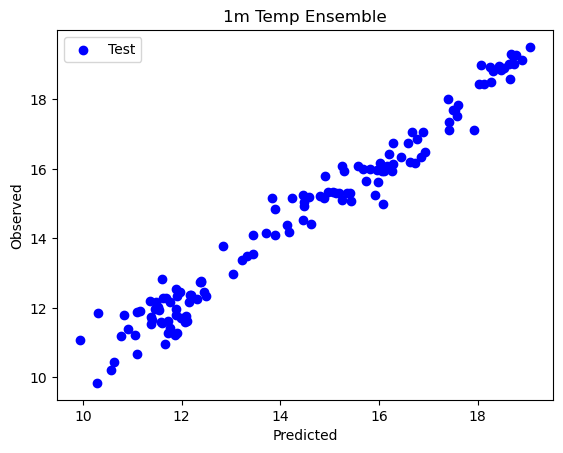

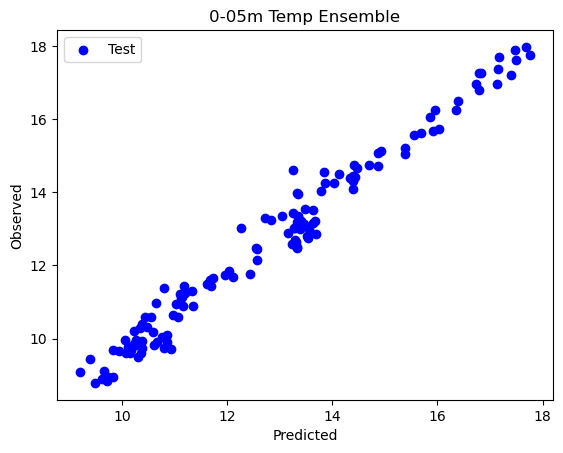

In [60]:
create_scatter_plot_test("1m Temp Ensemble", np.sqrt(test["ts_cv_ensemble_pred_1m"]), np.sqrt(test["mean_1m_temp_degC"]))
create_scatter_plot_test("0-05m Temp Ensemble", test["ts_cv_ensemble_pred_05m"], test["mean_0_5m_temp_degC"])

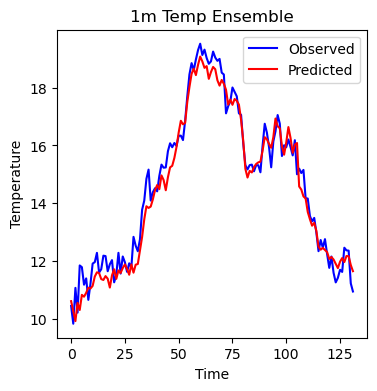

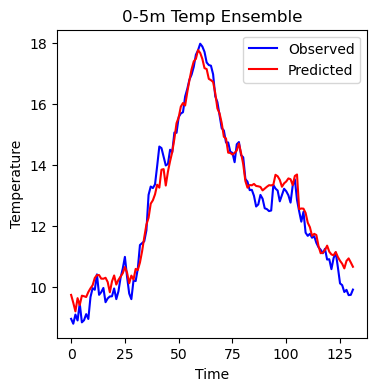

In [61]:
ts_plot(np.sqrt(test["mean_1m_temp_degC"]), np.sqrt(test["ts_cv_ensemble_pred_1m"]), "1m Temp Ensemble")
ts_plot(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"], "0-5m Temp Ensemble")


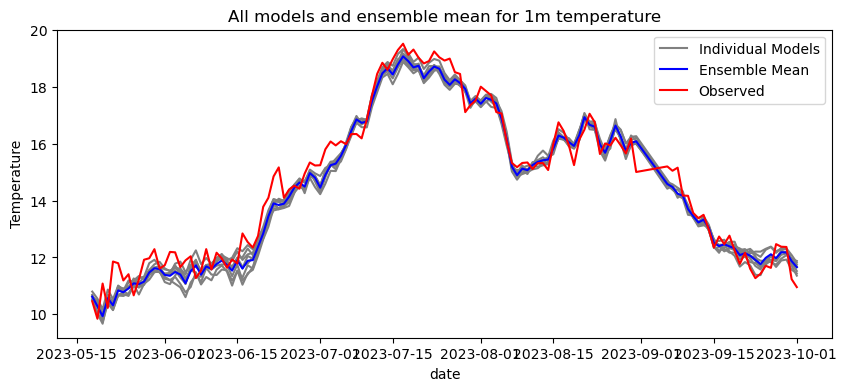

In [62]:
plt.figure(figsize=(10,4))
plt.plot(test['date'], np.sqrt(test["pred_1m_1"]), label="Individual Models", color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_2"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_3"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_4"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_5"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_6"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_7"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_8"]), color='grey')
plt.plot(test['date'], np.sqrt(test["ts_cv_ensemble_pred_1m"]), label="Ensemble Mean", color='blue')
plt.plot(test['date'], np.sqrt(test["mean_1m_temp_degC"]), label="Observed", color='red')
plt.xlabel("date")
plt.ylabel("Temperature")
plt.legend()
plt.title("All models and ensemble mean for 1m temperature")
plt.show()

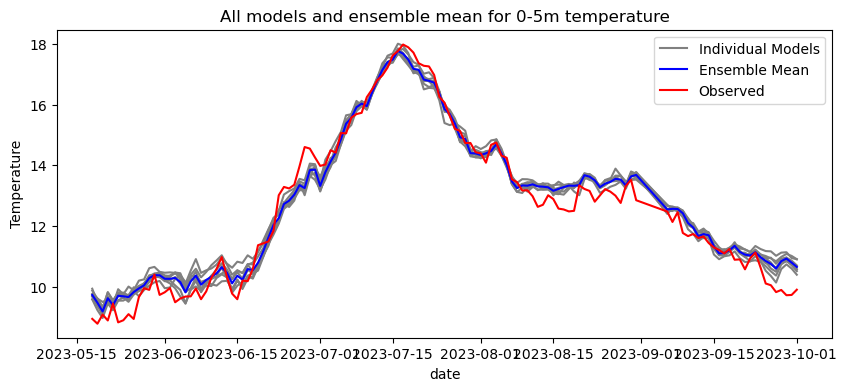

In [63]:
plt.figure(figsize=(10,4))
plt.plot(test['date'], test["pred_05m_1"], label="Individual Models", color='grey')
plt.plot(test['date'], test["pred_05m_2"], color='grey')
plt.plot(test['date'], test["pred_05m_3"], color='grey')
plt.plot(test['date'], test["pred_05m_4"], color='grey')
plt.plot(test['date'], test["pred_05m_5"], color='grey')
plt.plot(test['date'], test["pred_05m_6"], color='grey')
plt.plot(test['date'], test["pred_05m_7"], color='grey')
plt.plot(test['date'], test["pred_05m_8"], color='grey')
plt.plot(test['date'], test["ts_cv_ensemble_pred_05m"], label="Ensemble Mean", color='blue')
plt.plot(test['date'], test["mean_0_5m_temp_degC"], label="Observed", color='red')
plt.xlabel("date")
plt.ylabel("Temperature")
plt.legend()
plt.title("All models and ensemble mean for 0-5m temperature")
plt.show()

These actually look quite good. While the model doesn't capture the highest values at 1m, there were zero instances in the training/validation set with values that high, so it's not surprising that the model doesn't capture them. The model does a good job of capturing the general trends in the data and does very well with the high 0-5m values.


## Create timeseries residual plot

Calculate residuals

In [64]:
test['res_1m_1'] = np.sqrt(test['pred_1m_1']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_2'] = np.sqrt(test['pred_1m_2']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_3'] = np.sqrt(test['pred_1m_3']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_4'] = np.sqrt(test['pred_1m_4']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_5'] = np.sqrt(test['pred_1m_5']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_6'] = np.sqrt(test['pred_1m_6']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_7'] = np.sqrt(test['pred_1m_7']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_8'] = np.sqrt(test['pred_1m_8']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_ensemble'] = np.sqrt(test['ts_cv_ensemble_pred_1m']) - np.sqrt(test['mean_1m_temp_degC'])

test['res_05m_1'] = test['pred_05m_1'] - test['mean_0_5m_temp_degC']
test['res_05m_2'] = test['pred_05m_2'] - test['mean_0_5m_temp_degC']
test['res_05m_3'] = test['pred_05m_3'] - test['mean_0_5m_temp_degC']
test['res_05m_4'] = test['pred_05m_4'] - test['mean_0_5m_temp_degC']
test['res_05m_5'] = test['pred_05m_5'] - test['mean_0_5m_temp_degC']
test['res_05m_6'] = test['pred_05m_6'] - test['mean_0_5m_temp_degC']
test['res_05m_7'] = test['pred_05m_7'] - test['mean_0_5m_temp_degC']
test['res_05m_8'] = test['pred_05m_8'] - test['mean_0_5m_temp_degC']
test['res_05m_ensemble'] = test['ts_cv_ensemble_pred_05m'] - test['mean_0_5m_temp_degC']


In [ ]:
yit = test.filter(['mean_0_5m_temp_degC', 'mean_1m_temp_degC'])
yit = yit.shift(periods=1).rename(columns={'mean_0_5m_temp_degC': 'yit_mean_0_5m_temp_degC', 
                                     'mean_1m_temp_degC': 'yit_mean_1m_temp_degC'})

test = pd.concat([test, yit], axis=1)
test['res_yit_0_5m'] = test['yit_mean_0_5m_temp_degC'] - test['mean_0_5m_temp_degC']
test['res_yit_1m'] = np.sqrt(test['yit_mean_1m_temp_degC']) - np.sqrt(test['mean_1m_temp_degC'])


     yit_mean_0_5m_temp_degC  yit_mean_1m_temp_degC
0                        NaN                    NaN
1                   8.945925             109.311207
2                   8.785537              96.868901
3                   9.086389             122.784129
4                   8.892698             104.554033
..                       ...                    ...
127                10.052574             135.295669
128                 9.826889             155.419856
129                 9.897630             153.140625
130                 9.724222             152.926200
131                 9.733000             126.225225

[132 rows x 2 columns]


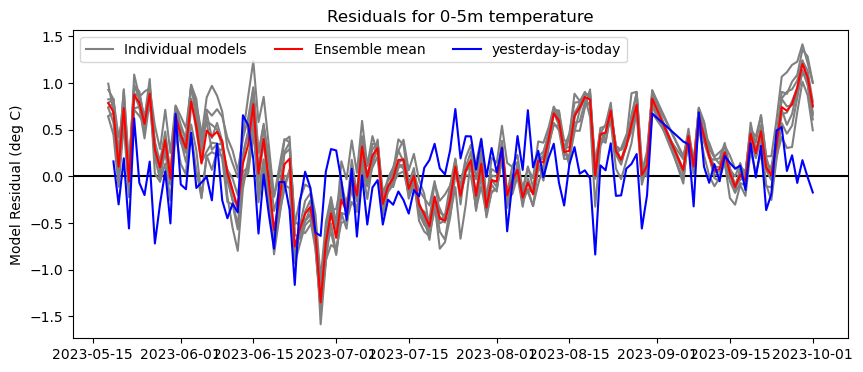

In [66]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_05m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_05m_2"], color='grey')
plt.plot(test['date'], test["res_05m_3"], color='grey')
plt.plot(test['date'], test["res_05m_4"], color='grey')
plt.plot(test['date'], test["res_05m_5"], color='grey')
plt.plot(test['date'], test["res_05m_6"], color='grey')
plt.plot(test['date'], test["res_05m_7"], color='grey')
plt.plot(test['date'], test["res_05m_8"], color='grey')
plt.plot(test['date'], test["res_05m_ensemble"], label="Ensemble mean", color='red')
plt.plot(test['date'], test["res_yit_0_5m"], label = "yesterday-is-today", color = 'blue')
plt.ylabel("Model Residual (deg C)")
plt.legend(ncols = 3)
plt.title("Residuals for 0-5m temperature")
plt.show()

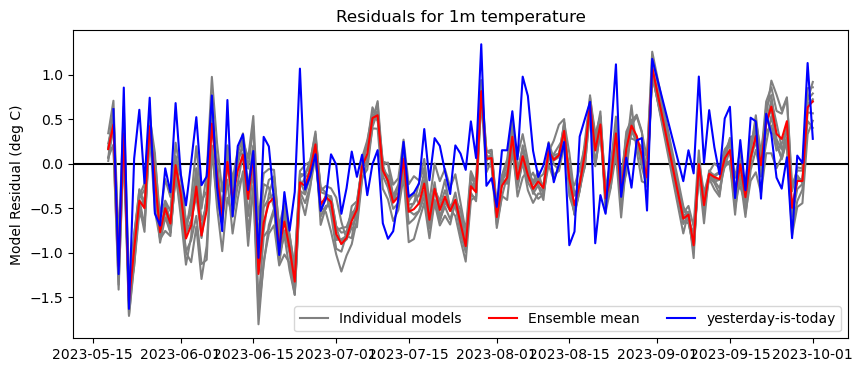

In [67]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_1m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_1m_2"], color='grey')
plt.plot(test['date'], test["res_1m_3"], color='grey')
plt.plot(test['date'], test["res_1m_4"], color='grey')
plt.plot(test['date'], test["res_1m_5"], color='grey')
plt.plot(test['date'], test["res_1m_6"], color='grey')
plt.plot(test['date'], test["res_1m_7"], color='grey')
plt.plot(test['date'], test["res_1m_8"], color='grey')
plt.plot(test['date'], test["res_1m_ensemble"], label="Ensemble mean", color='red')
plt.plot(test['date'], test["res_yit_1m"], label = "yesterday-is-today", color = 'blue')
plt.ylabel("Model Residual (deg C)")
plt.legend(ncols = 3)
plt.title("Residuals for 1m temperature")
plt.show()